In [6]:
import pandas as pd
import numpy as np
import os

print(os.getcwd())

/Users/nick/Dropbox/Datascience/Project_NWR


**Nick Weitao Rong, A.Ag, MSc** <br />
Junior Scientist at Knight Piésold Consulting <br />

# Purpose:
    The scope of the project is to use interpolated climate data to predict each year's annual maximum flood. If successful, such tool can be used to interpolate gaps in the peakflow record and perhaps allow some short-range extrapolation/prediction.

# Method:
## Data sources:
The annual maximum peakflow data are from Water Survey of Canada. The dataset is downloaded and extracted using a R package (tidyhydat) which is developed and maintained by the Data Science and Analytics Branch of the British Columbia Ministry of Citizens’ Services. The dataset is then exported as CSV files to be used in Python.

The weather data came from spatially interpolated weather station data (PRISM) and statistically downscaled by a software developed at UBC (ClimateBC). 

## Data screening & location of interest selection
Selection criteria:
1. Long record length
2. Snowmelt dominated (i.e. no on the island or coastal BC)
3. Sufficient climate station in the region (i.e. no northern BC area)



In [7]:
wsc_stn_info = pd.read_csv('./HYDAT_BC_station_info.csv')
wsc_stn_range = pd.read_csv('./HYDAT_BC_station_range.csv')

wsc_stn_meta = wsc_stn_info.merge(wsc_stn_range, on = 'STATION_NUMBER', how = 'left')

wsc_stn_meta.dtypes
wsc_stn_selected = wsc_stn_meta[(wsc_stn_meta['HYD_STATUS'] == 'ACTIVE') & 
                                 (wsc_stn_meta['DATA_TYPE'] == 'Q') &
                                 (wsc_stn_meta['RECORD_LENGTH'] > 70) &
                                 (wsc_stn_meta['DRAINAGE_AREA_GROSS'] < 500)]

wsc_stn_selected

,STATION_NUMBER,STATION_NAME,PROV_TERR_STATE_LOC,REGIONAL_OFFICE_ID,HYD_STATUS,SED_STATUS,LATITUDE,LONGITUDE,DRAINAGE_AREA_GROSS,DRAINAGE_AREA_EFFECT,RHBN,REAL_TIME,CONTRIBUTOR_ID,OPERATOR_ID,DATUM_ID,DATA_TYPE,SED_DATA_TYPE,Year_from,Year_to,RECORD_LENGTH
362,08GA010,CAPILANO RIVER ABOVE INTAKE,BC,2,ACTIVE,DISCONTINUED,49.396240,-123.145844,173.000000,NaN,True,False,55.0,647.0,11.0,Q,NaN,1914,2018,103
384,08GA030,SEYMOUR RIVER NEAR NORTH VANCOUVER,BC,2,ACTIVE,NaN,49.341980,-123.002121,179.000000,NaN,False,True,647.0,647.0,10.0,Q,NaN,1928,2018,90
507,08HA001,CHEMAINUS RIVER NEAR WESTHOLME,BC,2,ACTIVE,NaN,48.878361,-123.704643,355.000000,NaN,True,True,647.0,647.0,10.0,Q,NaN,1914,2018,71
595,08HB008,SPROAT RIVER NEAR ALBERNI,BC,2,ACTIVE,NaN,49.289719,-124.910278,351.000000,NaN,True,True,647.0,647.0,10.0,Q,NaN,1913,2017,97
1370,08LG016,PENNASK CREEK NEAR QUILCHENA,BC,2,ACTIVE,NaN,49.964920,-120.134933,87.599998,NaN,True,True,647.0,647.0,10.0,Q,NaN,1920,2015,74
1696,08MH016,CHILLIWACK RIVER AT OUTLET OF CHILLIWACK LAKE,BC,2,ACTIVE,NaN,49.083649,-121.458443,335.000000,NaN,True,False,647.0,647.0,10.0,Q,NaN,1923,2017,90
1979,08NE039,BIG SHEEP CREEK NEAR ROSSLAND,BC,2,ACTIVE,NaN,49.014648,-117.945297,347.000000,NaN,False,True,647.0,647.0,10.0,Q,NaN,1929,2018,72
2074,08NF001,KOOTENAY RIVER AT KOOTENAY CROSSING,BC,2,ACTIVE,NaN,50.887032,-116.046097,416.000000,NaN,True,True,647.0,647.0,10.0,Q,NaN,1939,2018,78


Best candidate is 08NF001 (Kootenay River at Kootenay Crossing) (50.887032, -116.046097) in the Rookie, 416 km2 drainage area, 1939-2018 (78 years), snowmelt dominated...

<img src="./Project_location.png" alt="Location"
	title="Project Location" width="800" height="1000" />

Read in the CSV file downloaded from water survey of canada <br />
https://wateroffice.ec.gc.ca/download/index_e.html?results_type=historical

The ClimateBC/WNA software is ran with the given coordinate to produce interpolated climate indecies (spatial downscalled PRISM data):

<img src="./ClimateWNA_example.png" alt="ClimateWNA"
	title="ClimateWNA page" width="800" height="1000" />
    
Read in the CSV output from ClimateBC.
Merge the flood data and weather data dataframes by year.

In [8]:
kootenay_flood = pd.read_csv('./08NF001_AnnualExtremesMax.csv')
kootenay_climate = pd.read_csv('./PRISM_data_at_08NF001_1930-2018S.csv')
kootenay = kootenay_flood.merge(kootenay_climate, on = 'Year', how = 'left')
kootenay.dropna(subset = ["MAX"], inplace=True)
df_clean = kootenay.dropna(axis='columns', how ='any').set_index('Year')

list(df_clean.columns)

[' ID',
 'PARAM',
 'MM--DD',
 'MAX',
 'ID1',
 'ID2',
 'Latitude',
 'Longitude',
 'Elevation',
 'Tmax_wt',
 'Tmax_sp',
 'Tmax_sm',
 'Tmax_at',
 'Tmin_wt',
 'Tmin_sp',
 'Tmin_sm',
 'Tmin_at',
 'Tave_wt',
 'Tave_sp',
 'Tave_sm',
 'Tave_at',
 'PPT_wt',
 'PPT_sp',
 'PPT_sm',
 'PPT_at',
 'DD_0_wt',
 'DD_0_sp',
 'DD_0_sm',
 'DD_0_at',
 'DD5_wt',
 'DD5_sp',
 'DD5_sm',
 'DD5_at',
 'DD_18_wt',
 'DD_18_sp',
 'DD_18_sm',
 'DD_18_at',
 'DD18_wt',
 'DD18_sp',
 'DD18_sm',
 'DD18_at',
 'NFFD_wt',
 'NFFD_sp',
 'NFFD_sm',
 'NFFD_at',
 'PAS_wt',
 'PAS_sp',
 'PAS_sm',
 'PAS_at',
 'Eref_wt',
 'Eref_sp',
 'Eref_sm',
 'Eref_at',
 'CMD_wt',
 'CMD_sp',
 'CMD_sm',
 'CMD_at',
 'RH_wt',
 'RH_sp',
 'RH_sm',
 'RH_at']

## Data column explanation (from ClimateBC software user manual)

Seasonal variables:
- Winter (_wt): Dec (prev. yr for an individual year) - Feb
- Spring (_sp): March, April and May
- Summer (_sm): June, July and August
- Autumn (_at): September, October and November 

Directly calculated seasonal variables:
- Tave_wt	winter mean temperature (°C)
- Tave_sp	spring mean temperature (°C)
- Tave_sm	summer mean temperature (°C)
- Tave_at	autumn mean temperature (°C)

- Tmax_wt	winter mean maximum temperature (°C)
- Tmax_sp	spring mean maximum temperature (°C)
- Tmax_sm	summer mean maximum temperature (°C)
- Tmax_at	autumn mean maximum temperature (°C)

- Tmin_wt	winter mean minimum temperature (°C)
- Tmin_sp	spring mean minimum temperature (°C)
- Tmin_sm	summer mean minimum temperature (°C)
- Tmin_at	autumn mean minimum temperature (°C)

- PPT_wt	winter precipitation (mm)
- PPT_sp	spring precipitation (mm) 
- PPT_sm	summer precipitation (mm) 
- PPT_at		autumn precipitation (mm)

- RAD_wt	winter solar radiation (MJ m‐2 d‐1)
- RAD_sp	spring solar radiation (MJ m‐2 d‐1)
- RAD_sm	summer solar radiation (MJ m‐2 d‐1)
- RAD_at	autumn solar radiation (MJ m‐2 d‐1)

Derived seasonal variables:
- DD_0_wt	winter degree-days below 0°C
- DD_0_sp	spring degree-days below 0°C
- DD_0_sm	summer degree-days below 0°C
- DD_0_at	autumn degree-days below 0°C

- DD5_wt	winter degree-days above 5°C
- DD5_sp	spring degree-days above 5°C
- DD5_sm	summer degree-days above 5°C
- DD5_at	autumn degree-days above 5°C

- DD_18_wt	winter degree-days below 18°C
- DD_18_sp	spring degree-days below 18°C
- DD_18_sm	summer degree-days below 18°C
- DD_18_at	autumn degree-days below 18°C

- DD18_wt	winter degree-days above 18°C
- DD18_sp	spring degree-days above 18°C
- DD18_sm	summer degree-days above 18°C
- DD18_at	autumn degree-days above 18°C

- NFFD_wt 	winter number of frost-free days
- NFFD_sp 	spring number of frost-free days
- NFFD_sm 	summer number of frost-free days
- NFFD_at 	autumn number of frost-free days

- PAS_wt 	winter precipitation as snow (mm)
- PAS_sp 	spring precipitation as snow (mm)
- PAS_sm 	summer precipitation as snow (mm)
- PAS_at 	autumn precipitation as snow (mm)

- Eref_wt 	winter Hargreaves reference evaporation (mm)
- Eref_sp 	spring Hargreaves reference evaporation (mm)
- Eref_sm 	summer Hargreaves reference evaporation (mm)
- Eref_at 	autumn Hargreaves reference evaporation (mm)

- CMD_wt 	winter Hargreaves climatic moisture deficit (mm)
- CMD_sp 	spring Hargreaves climatic moisture deficit (mm)
- CMD_sm 	summer Hargreaves climatic moisture deficit (mm)
- CMD_at 	autumn Hargreaves climatic moisture deficit (mm)

- RH_wt		winter relative humidity (%)
- RH_sp		winter relative humidity (%)
- RH_sm	winter relative humidity (%)
- RH_at		winter relative humidity (%)


## Weather data consideration

Snowmelt dominated flood is the target of interest because it is hypothesized that snowmelt induced floods are confined to only a few variables (how much snow on the ground and how warm is the freshet season). This is relatively less complicated than predicting storm precipitation induced flooding.

However, the freshet season in around May & June depends on the amount of snow accumulated since last year's October and onward (and therefore hydrologists use "water year" which starts in October). Therefore, there no point in correlating this year's summer and fall season to this year's freshet since the two seasons occur after this year's peakflow. Therefore, the summer and fall season weather indices should be shifted back one year (e.g.: 1984 winter match with 1983 summer & fall).

In [9]:
df = df_clean.drop([' ID',
                             'PARAM',
                             'MM--DD',
                             'ID1',
                             'ID2',
                             'Latitude',
                             'Longitude',
                             'Elevation'], axis=1)


df2 = df.copy()
df3 = df.copy()
df2 = df.loc[:, df.columns.str.contains('_sm') | df.columns.str.contains('_at')]

mask = (df3.columns.isin(list(df2.columns.values)))
cols_to_shift = df3.columns[mask]
df3[cols_to_shift] = df3.loc[:,mask].shift(1)

df4 = df3.iloc[1:]

In [6]:
df4

,MAX,Tmax_wt,Tmax_sp,Tmax_sm,Tmax_at,Tmin_wt,Tmin_sp,Tmin_sm,Tmin_at,Tave_wt,...,Eref_sm,Eref_at,CMD_wt,CMD_sp,CMD_sm,CMD_at,RH_wt,RH_sp,RH_sm,RH_at
Year,,,,,,,,,,,,,,,,,,,,,
1940,28.2,-3.6,8.2,19.0,7.8,-13.0,-2.4,3.3,-2.1,-8.3,...,323.0,77.0,0,0,160.0,0.0,60,63,53.0,65.0
1941,19.8,-2.4,9.5,20.9,7.3,-12.3,-3.2,4.0,-3.4,-7.3,...,350.0,91.0,0,50,172.0,0.0,59,56,50.0,62.0
1945,19.7,-4.0,5.1,19.9,6.1,-14.4,-5.6,5.1,-3.6,-9.2,...,331.0,69.0,0,0,87.0,0.0,57,61,55.0,65.0
1946,31.7,-4.0,8.2,19.3,5.7,-13.3,-3.4,3.8,-5.2,-8.6,...,326.0,79.0,0,0,53.0,0.0,60,60,53.0,61.0
1948,41.6,-4.3,4.9,19.1,5.1,-14.7,-6.1,3.2,-6.1,-9.5,...,327.0,79.0,0,0,48.0,0.0,56,59,52.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,28.3,-4.8,6.0,19.2,6.6,-13.1,-3.5,5.6,-2.8,-8.9,...,316.0,81.0,0,0,56.0,0.0,64,66,58.0,66.0
2015,23.7,-1.3,9.2,19.6,7.2,-9.1,-1.8,5.8,-2.1,-5.2,...,322.0,81.0,0,25,71.0,0.0,67,62,58.0,68.0
2016,17.9,-1.7,9.4,20.2,6.9,-9.2,-1.0,5.6,-2.7,-5.4,...,332.0,79.0,0,10,41.0,0.0,69,64,56.0,66.0


## Check Linearity and Model Selection

Manual model selection is conducted to look for linear relationship between weather indices and floods.
In tradiational statistics course on linear regression, step-wise model selection technique is taught but there's opinion that such step-wise is a black box approach and it does not work: https://towardsdatascience.com/stopping-stepwise-why-stepwise-selection-is-bad-and-what-you-should-use-instead-90818b3f52df

Instead, I decided to go with the "expert knowledge" method of selecting the model.

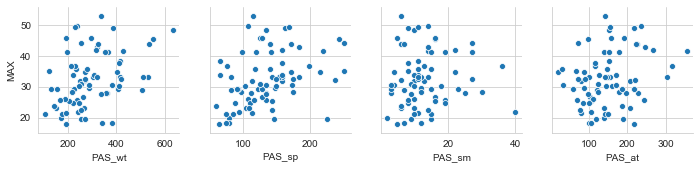

In [10]:
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

#sns.pairplot(df_small)
#sns.scatterplot(data=df, x='Tave_sp', y='MAX')

sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['PAS_wt', 'PAS_sp', 'PAS_sm', 'PAS_at'])

# some linear correlation between floods and winter/spring snowfall

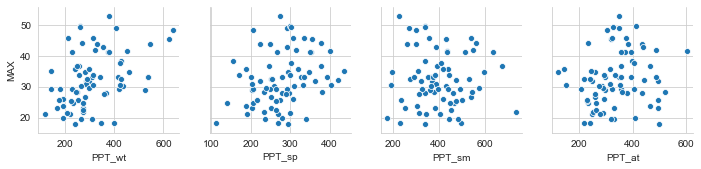

In [11]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['PPT_wt', 'PPT_sp', 'PPT_sm', 'PPT_at'])

# some linear correlation between floods and winter total precipitation
# Although, one of the 6 linear regression rules is that the independent variables are not self-correlated
# Since total precipitation is directly correlated with snowfall...ignored?

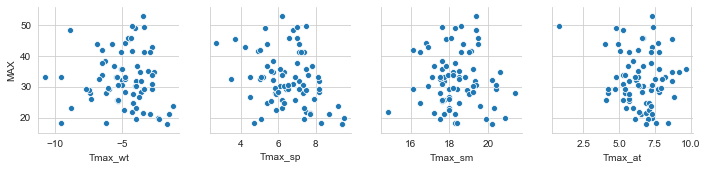

In [9]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['Tmax_wt', 'Tmax_sp', 'Tmax_sm', 'Tmax_at'])

# Makes sense that the spring (freshet season usually) maximum temperature negatively correlates with floods

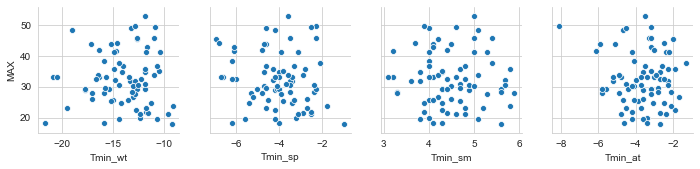

In [10]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['Tmin_wt', 'Tmin_sp', 'Tmin_sm', 'Tmin_at'])

# no correlation with minimum temperature...which makes sense

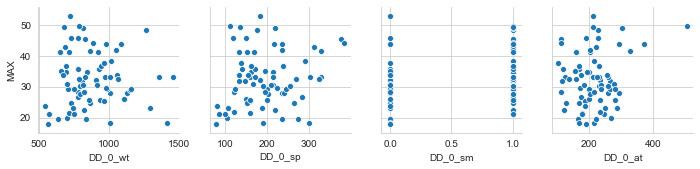

In [11]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['DD_0_wt', 'DD_0_sp', 'DD_0_sm', 'DD_0_at'])

#degree day above 0 is self-correlate with temperatures...ignore

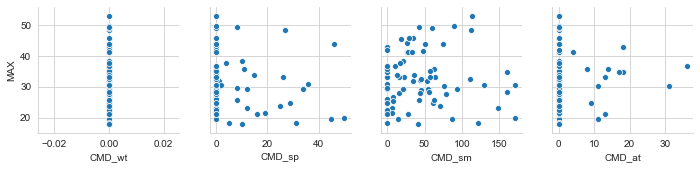

In [12]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['CMD_wt', 'CMD_sp', 'CMD_sm', 'CMD_at'])

# not seeing any correlation

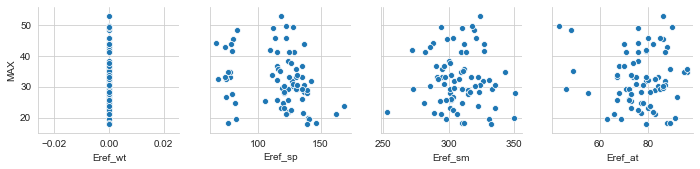

In [13]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['Eref_wt', 'Eref_sp', 'Eref_sm', 'Eref_at'])

# not seeing any correlation

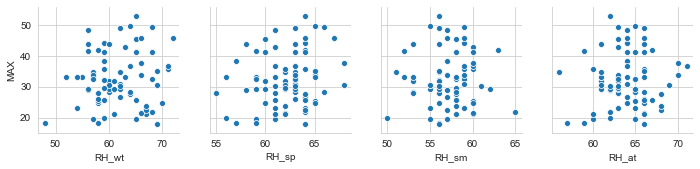

In [14]:
sns.pairplot(data=df4,
                  y_vars=['MAX'],
                  x_vars=['RH_wt', 'RH_sp', 'RH_sm', 'RH_at'])

# Some linear correlation with the spring relative humidity

## Multiple Linear Regression

y ~ PAS_wt + PAS_sp + Tmax_sp + RH_sp

Overall the model makes sense physically (depends on winter/spring precipitation and warm spell temperature of spring time).



In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

MLR = df4.copy()
MLR = df4[['MAX', 'PAS_wt', 'PAS_sp', 'Tmax_sp', 'RH_sp']]
MLR.describe()

,MAX,PAS_wt,PAS_sp,Tmax_sp,RH_sp
count,75.000000,75.000000,75.000000,75.000000,75.000000
mean,32.336000,294.480000,135.133333,6.486667,62.053333
std,8.679171,109.305345,45.819072,1.348105,2.710806
min,17.900000,105.000000,60.000000,2.700000,55.000000
25%,25.800000,222.000000,103.500000,5.650000,60.500000
50%,31.700000,269.000000,134.000000,6.500000,62.000000
75%,37.150000,360.500000,159.000000,7.400000,64.000000
max,53.000000,634.000000,251.000000,9.500000,68.000000


## Model Calibration and Validation
Set up the multiple linear model. Train the model with 80% of the data and validate the model with 20% of the data.

In [13]:
X = MLR[['PAS_wt', 'PAS_sp', 'Tmax_sp', 'RH_sp']]
y = MLR['MAX']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df


,Coefficient
PAS_wt,0.040327
PAS_sp,0.040126
Tmax_sp,0.183913
RH_sp,1.490392


Calibrated model for 08NF001 is:

Annual Flood = 0.04*(winter snowfall) + 0.04*(spring snowfall) + 0.18*(spring max temperature) + 1.49*(spring relative humidity)

Now validate this model with the remaining 20% of the data.

In [15]:
y_pred = regressor.predict(X_test)
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residuals': y_test-y_pred})
df_pred1 = df_pred.head(25)
df_pred1

,Actual,Predicted,Residuals
0,42.0,36.880469,5.119531
1,25.6,29.455434,-3.855434
2,41.3,30.848128,10.451872
3,30.7,42.550507,-11.850507
4,48.4,44.520892,3.879108
5,24.7,24.312267,0.387733
6,21.3,22.917730,-1.617730
7,21.5,27.509380,-6.009380
8,33.7,38.228613,-4.528613
9,33.1,32.657275,0.442725


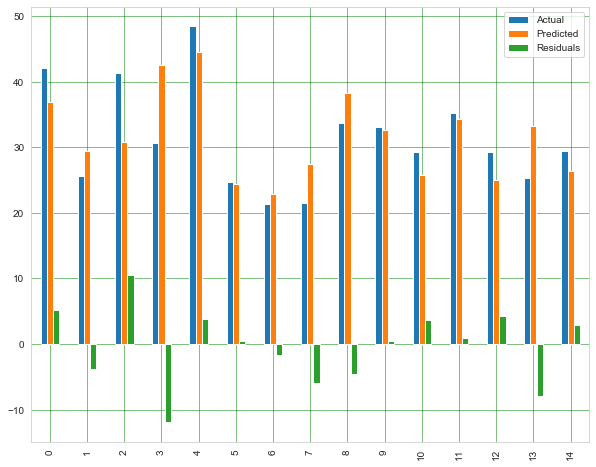

In [38]:
# Plot bar plot to compare actual vs predicted

df_pred1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Checking Linear Model Assumptions

Bad things happen if the 6 assumptions of linear regression are not met, so we need to check them 

1. The relationship between the x’s and y is linear (Checked during model selection process)
2. Homoscedasticity (equal variance) (checked using the variance scatter plot below, make sure no cone or trend)
3. Independent of observations (x & y) (although the floods Y might be auto-correlate in time due to climatic decadal osscilation...we will assume this assumption is met. For Xs, effort has been spent on avoiding correlation between variables (i.e. not including both temperatures and degree day above certain temperature)
4. Normality (checked using the normality plot below)

Assumption 5 & 6 are about measurement and collection of sample data (no measurement error samples are unbiased from the population...which we just assume these assumptions are met).

Sources:
- LeMay, V.M., (2014), *FRST533C Advanced biometrics course note package*, UBC Forestry.
- Kutner, M. H., Nachtsheim, C. J., Neter, J., & Li, W. (2005). *Applied linear statistical models* (Vol. 5). New York: McGraw-Hill Irwin.


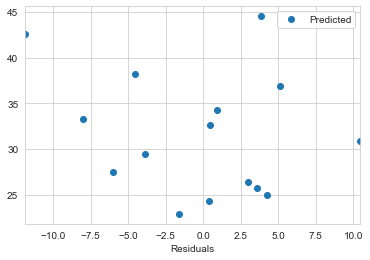

In [16]:
df_pred1.plot(x='Residuals', y='Predicted', style = 'o')

0.9710524430998326

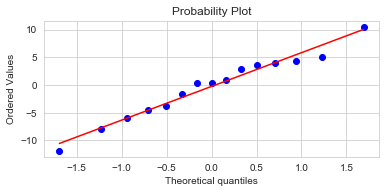

In [17]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(df_pred1['Residuals'], plot=ax, fit=True)
r**2

# normal enough? The high tail is a bit not sure...

Below is an example of when assumptions are not met (i.e.: not equal, increasing variance of residuals and non-normal residuals) (From LeMay, V.M., (2014), *FRST533C Advanced biometrics course note package*, UBC Forestry)

<img src="./example_of_bad_MLR.png" alt="BadExample"
	title="Bad Example of MLR" width="400" height="500" />

**In conclusion**...the assumptions are met...good enough

In [72]:
# Validation & Performance Measurements

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.525396639148882
Mean Squared Error: 31.325621826303937
Root Mean Squared Error: 5.596929678520532


In [41]:
MAX_mean = MLR.describe().iloc[1,0] #what's the mean annual flood?
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

RMSE/MAX_mean * 100

17.30866427053604

# Conclusion & Limitations

The predicted annual floods using only 4 weather indecies (winter/spring snowfall, spring max temperature, and spring relative humidity) are 17% different from the measured annual flood in the validation dataset. This is a good performance given the simplicity of the model (only 4 variables!). And in the practice of hydrology, 17% is not that hard to sell given the uncertain nature of flood runoff generation. The model outcome also supports the hypothesis that snowmelt dominated region's annual flood is perhaps easier to predict.

It is worth mentioning that this model follows the simplicity rule of modelling (simpler the better) and it can be easily defended using physics and hyrological processes. Potential limitation of this methodology is the requirement of long record length for calibrtion. As this may not be possible for most parts of the province & country. Also, from the comparison of predicted vs observed, the performance is worse for extreme floods (but ot bad enough to violate equal variance assumption given the dataset). This is not surprising for predictions coming out of regression method, however, attention must be given when using this method on condition deviated too much from the mean annual flood.